# QGAN

## Imports

In [ ]:
!pip install pennylane

In [ ]:
import pennylane as qml
import torch
from pennylane import numpy as np
from matplotlib import pyplot as plt
from torch.optim import Adam
from torch.autograd import Variable
import sys
from tqdm import tqdm
import json
import pandas as pd

plt.style.use('seaborn') # pretty matplotlib plots

<ipython-input-27-47d23bdda390>:12: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn') # pretty matplotlib plots


In [ ]:
!pip install pylatexenc

# Model

## Generator layers
in the paper, the circuit is composed of alternating rotation layers and entangling CZ blocks.

In [ ]:
def rotation_layer(w):
    for i in range(num_qubits):
        qml.RY(w[i], wires=i)

In [ ]:
def entangling_block():
    for i in range(num_qubits):
        qml.CZ(wires = [i, (i+1)%num_qubits])

In [ ]:
def generator_circuit(w, num_qubits, num_layers = 3):
    # if init_strategy == "uniform":
    #     qml.Hadamard(wires=range(num_qubits)

    """
    rotation -> (entangling -> rotation) * num_layers
    """
    rotation_layer(w[:num_qubits])
    for i in range(num_qubits, num_layers * (num_qubits + 1), num_qubits):
        entangling_block()
        rotation_layer(w[i :i + num_qubits])

    return qml.sample(wires=range(num_qubits))

## Classical Discriminator
Simple FCNN

In [ ]:
# define classical discriminator
# TLDR; takes in a sample and outputs a single number, where closer to 0 = fake and closer to 1 = real
from torch import nn

class Discriminator(nn.Module):
    def __init__(self, input_size):
        super(Discriminator, self).__init__()

        self.linear_input = nn.Linear(input_size, 50)
        self.h1 = nn.Linear(50, 20)
        self.leaky_relu = nn.LeakyReLU(0.2)
        self.linear20 = nn.Linear(20, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, input: torch.Tensor) -> torch.Tensor:
        x = self.linear_input(input)
        x = self.leaky_relu(x)
        x = self.h1(x)
        x = self.leaky_relu(x)
        x = self.linear20(x)
        x = self.sigmoid(x)
        return x

# Training

## Helper Functions

In [ ]:
# generate data
from scipy.stats import lognorm, norm, triang
import matplotlib.pyplot as plt

def gauss(x,mu,sigma,A):
    return A*exp(-(x-mu)**2/2/sigma**2)

"""
params: type of distribution, # discrete values
output: the x values, and an np.array representing the probability values of the PMF
"""
def generate_data(which = "log-normal", num_discrete_values = 8):

    x = np.linspace(0,7, num_discrete_values)

    if which == "log-normal":
        rv = lognorm.pdf(x, 1)
    elif which == "triangular":
        """
        triangular distribution with:
            lower limit l = 0
            upper limit u = 7
            mode m = 2
        """
        a = 0
        b = 7
        mode = 2
        # list_of_candidates = range(a, b+1)
        rv = triang.pdf(x, mode/(b-a), a, b)


    else: #bimodal
        """
        bimodal distribution with:
            two superimposed Guassian distributions with
            mu_1 = 0.5
            sigma_1 = 1

            mu_2 = 3.5
            sigma_2 = 0.5
        """
        gauss1 = norm.pdf(x, 0.5, 1)
        gauss2 = norm.pdf(x, 3.5, 0.5)
        rv = (gauss1 + gauss2) / (np.sum(gauss1) + np.sum(gauss2))


    # fig, ax = plt.subplots(1, 1)
    # ax.plot(x, rv,'r-', lw=5, alpha=0.6, label='lognorm pdf')

    rv /= np.sum(rv) # normalization

    return x, rv

In [ ]:
# initialization strategy for weights
def init_weights(init_strategy, size):
    if init_strategy == "normal":
        params = np.random.normal(0, np.pi, size = size)
    elif init_strategy == "uniform":
        params = np.random.uniform(-0.1, 0.1, size = size)
    else: # random
        params = np.random.uniform(-np.pi, np.pi, size = size)

    params = Variable(torch.Tensor(params), requires_grad = True)

    return params

In [ ]:
# cost function
def gen_loss(x): # maximize the discriminator misclassifying fake data
    # print(f"gen loss input: {x}")
    loss = torch.log(x + sys.float_info.min)
    # loss = torch.log(1 - x)
    # print(f"loss: {loss}")
    return -torch.mean(loss)

def disc_loss(real, fake): # log(real) = maxed when disc correctly classifies real data; log(1 - fake) = maxed when disc correctly classifies fake data
    # print(f"disc loss input: {real}, {fake}")
    loss = torch.log(real + sys.float_info.min) + torch.log(1 - fake + sys.float_info.min)
    # print(f"loss: {loss}")
    return -torch.mean(loss) # discriminator is updated via gradient ASCENT

In [ ]:
"""
convert arrays representing binary values into their decimal form
@param an n x num_qubits array of binary arrays,
@param # qubits
returns: n decimal integers
"""
def binary_to_decimal(binary_arrays, num_qubits):
    binary_matrix = np.array(binary_arrays)
    powers = 2 ** np.arange(num_qubits - 1, -1, -1)

    decimal_values = np.sum(binary_matrix * powers, axis=1)
    return decimal_values

In [ ]:
# inverse function to above
def decimal_to_binary(decimal_values, array_length):
    decimal_array = np.array(decimal_values)

    binary_arrays = []
    for dec_value in decimal_array:
        binary_array = []
        for _ in range(array_length):
            remainder = dec_value % 2
            binary_array.insert(0, remainder)
            dec_value //= 2
        binary_arrays.append(binary_array)

    return binary_arrays

In [ ]:
"""
input: discrete x values, their corresponding probabilities, and the # samples you want
returns: num_samples samples
"""
def sample_pdf(x, pmf_values, num_samples):
    samples = np.random.choice(x, size=num_samples, p=pmf_values)
    return samples

In [ ]:
from scipy.stats import entropy
# reconstruct a PMF from an array of samples
def convert_samples_to_pmf(samples, possible_values):
  value_counts = np.array([np.count_nonzero(samples == i) for i in possible_values])

  # Calculate probabilities by dividing the value counts by the total number of samples
  total_samples = len(samples)
  pmf = value_counts / total_samples

  return pmf

# computes the rel entropy between 2 sets of samples
def compute_entropy(gen_samples, real_samples, possible_values):
  # Calculate the unique values and their frequencies
  fake_dist = convert_samples_to_pmf(gen_samples, possible_values)
  real_dist = convert_samples_to_pmf(real_samples, possible_values)

  return entropy(fake_dist + sys.float_info.min, real_dist + sys.float_info.min)

In [ ]:
# the quantum generator returns an array of samples in binary array form. We want to convert those values into a PMF for post-training evaluation
def convert_generator_output_to_pdf(gen_out, num_qubits):
  res = binary_to_decimal(gen_out, num_qubits)
  res = convert_samples_to_pmf(res, range(2**num_qubits))
  return res

In [ ]:
# visualize training process
from IPython.display import clear_output

def plot_training_progress(generator_loss_values, discriminator_loss_values, entropy_values):
    # we don't plot if we don't have enough data
    if len(generator_loss_values) < 2:
        return

    clear_output(wait=True)
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 9))

    # Generator Loss
    ax1.set_title("Loss")
    ax1.plot(generator_loss_values, label="generator loss", color="royalblue")
    ax1.plot(discriminator_loss_values, label="discriminator loss", color="magenta")
    ax1.legend(loc="best")
    ax1.set_xlabel("Iteration")
    ax1.set_ylabel("Loss")
    ax1.grid()

    # Relative Entropy
    ax2.set_title("Relative entropy")
    ax2.plot(entropy_values)
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("Relative entropy")
    ax2.grid()

    plt.show()

In [ ]:
# training loop
# logic inspired by https://towardsdatascience.com/build-a-super-simple-gan-in-pytorch-54ba349920e4
import time
from scipy.stats import multivariate_normal, entropy

def train(n_epochs, num_qubits, num_layers, distribution, batch_size, init_strategy = "normal", sample_size = 20000):
    num_discrete_values = 2**num_qubits

    # init generator
    num_qnn_outputs = 2**num_qubits

    params = init_weights(init_strategy, size = (num_layers + 1) * (num_qubits))

    dev = qml.device("default.qubit", wires=num_qubits, shots = batch_size) # 2000 as in the paper
    generator = qml.QNode(generator_circuit, dev, interface="torch", cache = False)

    # init discriminator
    # discriminator = Discriminator(input_size = num_discrete_values)
    discriminator = Discriminator(input_size = 1)

    # init optimizers
    lr = 1e-3
    # lr = 0.01
    # betas = (0.7, 0.999)

    # generator_optimizer = Adam([params], lr=lr, betas=betas, weight_decay=0.005) # paper didn't mention what momentum terms were used so I'm going with the default
    # discriminator_optimizer = Adam(discriminator.parameters(), lr=lr, betas=betas, weight_decay=0.005)

    generator_optimizer = Adam([params], lr=lr, amsgrad=True) # paper didn't mention what momentum terms were used so I'm going with the default
    discriminator_optimizer = Adam(discriminator.parameters(), lr=lr, amsgrad=True)

    # generate the training data
    grid_elements, prob_data = generate_data(distribution, num_discrete_values)
    training_samples = sample_pdf(grid_elements, prob_data, sample_size)




    # for training statistics
    generator_loss_values = []
    discriminator_loss_values = []
    entropy_values = []
    grad_vals = []

    # track optimal parameters # TODO: actually use these
    best_gen_loss = float("inf")
    best_gen_params = params
    best_disc_loss = float("inf")
    best_disc_params = discriminator.parameters()
    best_entropy = float("inf")
    best_generation = generator(params, num_qubits, num_layers)

    # actual training loop
    start = time.time()
    for epoch in tqdm(range(n_epochs)):
      # Shuffle the array randomly
      np.random.shuffle(training_samples)

      # Batch the shuffled array into batches of 2,000 items
      batches = [training_samples[i:i+batch_size] for i in range(0, sample_size, batch_size)]

      for i, batch in enumerate(batches):

        # zero gradients
        generator_optimizer.zero_grad()

        # generate real data
        # real_dist = torch.tensor(prob_data, dtype=torch.float)
        real_samples = torch.Tensor(batch)

        # generate fake data
        gen_dist = generator(params, num_qubits, num_layers)
        # gen_dist = gen_dist.type(torch.float)
        gen_samples = binary_to_decimal(gen_dist, num_qubits)
        gen_samples = torch.Tensor(gen_samples).reshape(-1,1)

        # train generator using discriminator output & fake labels
        # We invert the labels here and don't train the discriminator because we want the generator
        # to make things the discriminator classifies as true.
        discriminator_optimizer.zero_grad()

        # disc_out_fake = discriminator(gen_dist)
        disc_out_fake = discriminator(gen_samples)
        generator_loss = gen_loss(disc_out_fake)
        generator_loss_values.append(generator_loss.detach().item())

        generator_loss.backward(retain_graph=True) # NO GRAD???
        # grad_val = torch.autograd.grad(generator_loss, params, retain_graph=True)[0][-1] #choose the last parameter because the tutorial does so
        # grad_vals.append(grad_val.detach().numpy())
        generator_optimizer.step()

        # train discrminator on both a true and a generated data and average
        # disc_out_real = discriminator(real_dist)
        disc_out_real = discriminator(real_samples.reshape(-1,1))
        discriminator_loss = disc_loss(disc_out_real, disc_out_fake)
        discriminator_loss_values.append(discriminator_loss.detach().item())

        discriminator_loss.backward()
        discriminator_optimizer.step()

        # print(gen_dist)
        # batch_entropy = entropy(gen_dist.detach().squeeze().numpy() + sys.float_info.min, prob_data + sys.float_info.min) # RELATIVE ENTROPY
        batch_entropy = compute_entropy(gen_samples.detach().squeeze().numpy(), real_samples.detach().squeeze().numpy(), range(num_discrete_values))
        if batch_entropy < best_entropy:
            # print(batch_entropy)
            # print(gen_dist.detach().squeeze().numpy())
            best_gen_params = params.clone()
            best_disc_params = discriminator.parameters()
            best_entropy = batch_entropy
            best_generation = convert_generator_output_to_pdf(gen_dist.detach().squeeze().numpy(), num_qubits)
        entropy_values.append(batch_entropy)

        # plot_training_progress(generator_loss_values, discriminator_loss_values, entropy_values)

    elapsed = time.time() - start
    print(f"Fit in {elapsed:2f} sec")

    return {
        "num_gen_params": len(params),
        "num_disc_params": sum(p.numel() for p in discriminator.parameters()),
        "entropy_values": entropy_values,
        "generator_loss_values": generator_loss_values,
        "discriminator_loss_values": discriminator_loss_values,
        "final_generated_distribution": convert_generator_output_to_pdf(generator(best_gen_params, num_qubits, num_layers).detach().numpy(), num_qubits),
        "final_generated_distribution_last_params": convert_generator_output_to_pdf(generator(params, num_qubits, num_layers).detach().numpy(), num_qubits),
        "best_generation": best_generation,
        "real_distribution": prob_data,
        "training_time": elapsed,
        # TODO: generate 500 samples for KS test
        # "grad_variance": np.var(grad_vals)
    }

    # TODO: initialization strategy idk how to do boolean logic in the circuit itself

In [ ]:
# TODO write a testing suite
# plots training loss, rel. entropy, and generated vs. real distributions in a 3-column format, given a list of training instances
def plot_values(training_instances, height = 24):
    fig, axes = plt.subplots(len(training_instances), 3, figsize=(18, height), constrained_layout = True)

    for i, training_instance in enumerate(training_instances):
        # print(training_instance)

        num_qubits = training_instance["num_qubits"]
        num_layers = training_instance["num_layers"]
        generator_loss_values = training_instance["generator_loss_values"]
        discriminator_loss_values = training_instance["discriminator_loss_values"]
        entropy_values = training_instance["entropy_values"]
        distribution = training_instance["distribution"]
        gen_dist = training_instance["final_generated_distribution"]
        gen_dist2 = training_instance["final_generated_distribution_last_params"] # remove in actual results
        best_gen = training_instance["best_generation"] # remove in actual results
        real_dist = training_instance["real_distribution"]
        x = np.linspace(0,7,2**int(num_qubits))

        best_entropy = min(entropy_values)
        xpos = np.argmin(entropy_values)



        if len(generator_loss_values) < 2:
            pass

        # ax1, ax2 = axes[i % ((len(training_instances) + 1) // 2)][(i >= len(training_instances) // 2)*2:(i >= len(training_instances) // 2)*2+2]
        ax1, ax2, ax3 = axes[i] if len(training_instances) > 1 else axes

        # Generator Loss
        ax1.set_title(f"{distribution}, {num_qubits} qubits, {num_layers} layers (Loss)")
        ax1.plot(generator_loss_values, label="generator loss", color="royalblue")
        ax1.plot(discriminator_loss_values, label="discriminator loss", color="magenta")
        ax1.legend(loc="best")
        ax1.set_xlabel("Iteration")
        ax1.set_ylabel("Loss")
        ax1.grid()

        # Relative Entropy
        ax2.set_title(f"{distribution}; {num_qubits} qubits, {num_layers} layers (Relative Entropy)")
        ax2.plot(entropy_values)
        ax2.set_xlabel("Iteration")
        ax2.set_ylabel("Relative entropy")
        ax2.scatter(xpos, best_entropy, c = 'r', label = f"best = {best_entropy:.2f}")
        ax2.legend()
        ax2.grid()

        ax3.set_title(f"{distribution}; {num_qubits} qubits, {num_layers} layers (Generated vs. Actual Distribution)")
        ax3.plot(x, gen_dist, label = "generated w/ best params")
        ax3.plot(x, gen_dist2, label = "generated w/ final params")
        ax3.plot(x, best_gen, label = "best generation during training")
        ax3.plot(x, real_dist, label = "real")
        ax3.set_xlabel("x")
        ax3.set_ylabel("P(x)")
        ax3.legend()
        ax3.grid()
        print("Best relative entropy: ", min(training_instance["entropy_values"]))


    plt.show()
    plt.savefig("results.jpg")

In [ ]:
# optional: load in previously saved training instances
# training_instances = torch.load("model.pt")

In [ ]:
# len(training_instances)

In [ ]:
# for barren plateaus analysis
# variances = []
# for _, training_instance in enumerate(training_instances):
#     variances.append(training_instance["grad_variance"])

In [ ]:
#BP plot
# plt.title("Gradient Variance vs. # qubits")
# plt.xlabel("# qubits")
# plt.ylabel("gradient variance (of the last parameter across time)")
# plt.plot(range(2,16), variances)
# plt.show()

## Run training loop with different hyperparams

training for case: log-normal, 6 qubits, 3 layers


100%|██████████| 2000/2000 [12:00<00:00,  2.78it/s]


Fit in 720.377871 sec
Best relative entropy:  578.2380734456473


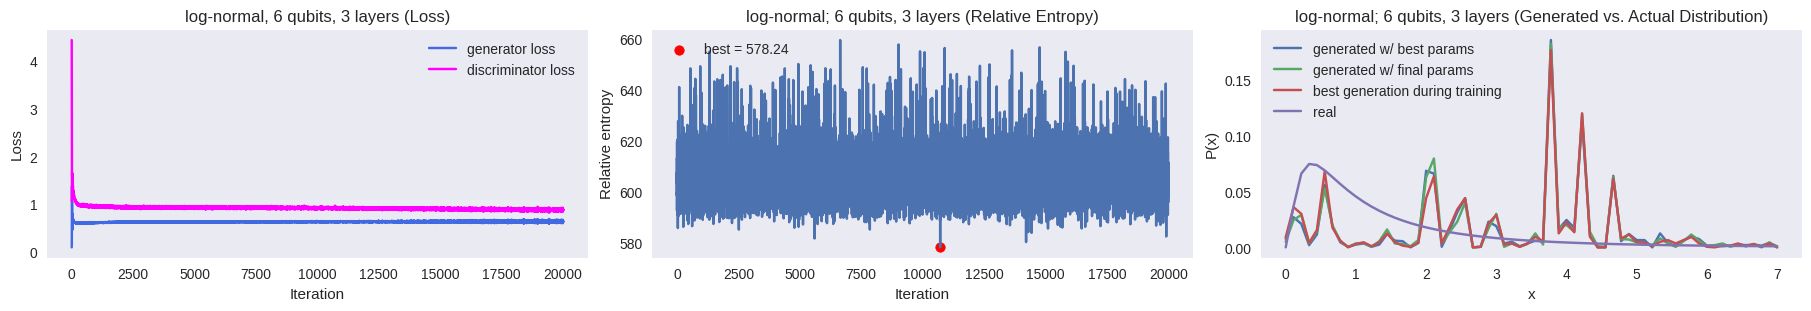

<Figure size 800x550 with 0 Axes>

In [ ]:
# run training
distributions = ["log-normal"]
# qbits = range(2,3)
qbits = [6]
n_epochs = 2000 # TODO: maybe tweak this?
layers = [3] # TODO: tweak
batch_size = 2000

training_instances = []
training_times = {}

# training_instances = torch.load("model.pt")

for distribution in distributions:
    training_times[distribution] = {}
    for num_layers in layers:
        training_times[distribution][num_layers] = []
        for num_qubits in qbits:
            print(f"training for case: {distribution}, {num_qubits} qubits, {num_layers} layers")
            training_instance = train(n_epochs, num_qubits, num_layers, distribution, batch_size)
            training_instance["num_qubits"] = f"{num_qubits}"
            training_instance["distribution"] = f"{distribution}"
            training_instance["num_layers"] = f"{num_layers}"
            training_times[distribution][num_layers].append(training_instance["training_time"])
            training_instances.append(training_instance)

            torch.save(training_instances, "model.pt")

# Evaluation

In [ ]:
# plot the training loss, relative entropy, and the generated vs. actual distributions
plot_values(training_instances, height = len(qbits) * len(layers) * len(distributions) * 3)

### Kolmogorov-Smirnov Test

The Kolmogorov-Smirnov statistic is based
on the (empirical) cumulative distribution functions
P (X ≤ x) and Q (X ≤ x).


The statistic can be used as a goodness-of-fit test.
Given the null-hypothesis P (x) = Q (x), we draw s =
500 samples from both distributions and choose a confidence level (1 − α) with α = 0.05. The null-hypothesis is
accepted if D <= 0.0859 [Zoufal et. al, 2019] (or if p <= 0.05) because statistics



In [ ]:
# KS TEST
x, rv = generate_data("log-normal", 2**6)
# sample from the PMF that I already generated which probably isn't the right way to do this
gv = training_instances[0]["final_generated_distribution"]

gen_samples = sample_pdf(x, gv, 500)
real_samples = sample_pdf(x, rv, 500)

(array([20., 34., 34., 30., 32., 29., 36., 25., 23., 20., 11., 13., 10.,
        15., 12., 10., 17., 12.,  8.,  9.,  7.,  0.,  8.,  4.,  6.,  3.,
         3.,  2.,  4.,  8.,  2.,  4.,  2.,  4.,  2.,  1.,  4.,  0.,  2.,
         2.,  3.,  1.,  0.,  3.,  4.,  1.,  0.,  1.,  0.,  5.,  1.,  1.,
         1.,  1.,  0.,  1.,  0.,  1.,  1.,  1.,  3.,  2.,  0.,  1.]),
 array([0.11111111, 0.21701389, 0.32291667, 0.42881944, 0.53472222,
        0.640625  , 0.74652778, 0.85243056, 0.95833333, 1.06423611,
        1.17013889, 1.27604167, 1.38194444, 1.48784722, 1.59375   ,
        1.69965278, 1.80555556, 1.91145833, 2.01736111, 2.12326389,
        2.22916667, 2.33506944, 2.44097222, 2.546875  , 2.65277778,
        2.75868056, 2.86458333, 2.97048611, 3.07638889, 3.18229167,
        3.28819444, 3.39409722, 3.5       , 3.60590278, 3.71180556,
        3.81770833, 3.92361111, 4.02951389, 4.13541667, 4.24131944,
        4.34722222, 4.453125  , 4.55902778, 4.66493056, 4.77083333,
        4.87673611, 4.9826

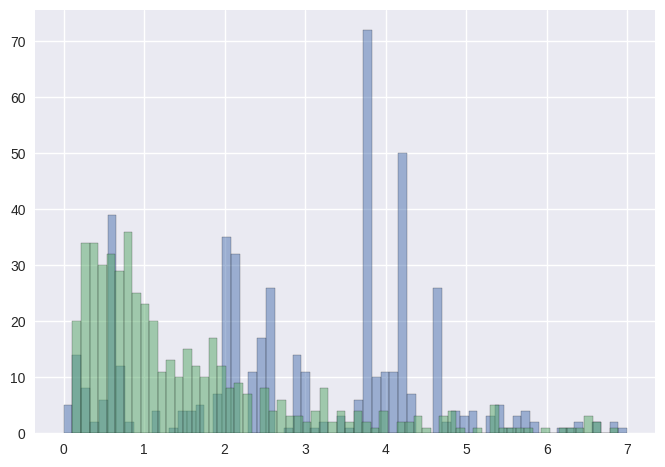

In [ ]:
# first we plot the distributions for a quantitative look
plt.hist(gen_samples, bins=64, alpha=0.5, edgecolor='black')
plt.hist(real_samples, bins=64, alpha=0.5, edgecolor='black')

In [ ]:
from scipy.stats import kstest
kstest(gen_samples, real_samples) # threshold for statistic is 0.0859

KstestResult(statistic=0.516, pvalue=4.630555380587149e-61, statistic_location=1.8888888888888888, statistic_sign=-1)